# Singapore Government Tender Analysis - Data Preprocessing

This notebook performs comprehensive data preprocessing for the Singapore Government Tender dataset. It follows the configuration-driven approach defined in `config.yaml`.

## Overview

1. **Data Loading**: Efficient data loading with memory considerations
2. **Data Cleaning**: Handle missing values, duplicates, and data types
3. **Feature Engineering**: Create date, text, and derived features
4. **Categorical Encoding**: Transform categorical variables
5. **Data Preparation**: Prepare datasets for different modeling tasks

**Note**: This notebook reads data efficiently using `nrows` parameter to manage memory usage with large datasets.

In [1]:
# Import required libraries
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml

# Add src directory to path for imports
sys.path.append(str(Path().absolute().parent / 'src'))

from preprocessing import TenderDataPreprocessor, preprocess_pipeline

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', None)

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully")

Libraries imported successfully


## 1. Configuration Loading

Load the configuration file to understand the data structure and processing settings.

In [2]:
# Load configuration
config_path = Path().absolute().parent / 'config.yaml'

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print("Configuration loaded successfully")
print(f"\nProject: {config['project']['name']}")
print(f"Version: {config['project']['version']}")
print(f"\nData source: {config['data']['source_file']}")
print(f"\nColumn mapping:")
for key, value in config['data']['columns'].items():
    print(f"  {key}: {value}")

Configuration loaded successfully

Project: Singapore Government Tender Analysis
Version: 1.0.0

Data source: Datasets/GovernmentProcurementviaGeBIZ.xlsx

Column mapping:
  tender_no: tender_no
  tender_description: tender_description
  agency: agency
  award_date: award_date
  tender_detail_status: tender_detail_status
  supplier_name: supplier_name
  awarded_amt: awarded_amt


## 2. Initial Data Exploration

Load a small sample of data to understand the structure before full processing.

In [3]:
# Read first 1000 rows for initial exploration
data_path = Path().absolute().parent / config['data']['source_file']

if data_path.suffix == '.csv':
	sample_df = pd.read_csv(data_path, nrows=1000)
elif data_path.suffix in ['.xls', '.xlsx']:
	sample_df = pd.read_excel(data_path, nrows=1000)

print(f"Sample data shape: {sample_df.shape}")
print(f"\nColumn names:")
for i, col in enumerate(sample_df.columns, 1):
    print(f"{i:2d}. {col}")

print(f"\nData types:")
print(sample_df.dtypes)

print(f"\nFirst 5 rows:")
display(sample_df.head())

Sample data shape: (1000, 11)

Column names:
 1. tender_no
 2. tender_description
 3. agency
 4. award_date
 5. tender_detail_status
 6. supplier_name
 7. awarded_amt
 8. is_outlier
 9. risk_label
10. agency_id
11. supplier_id

Data types:
tender_no                object
tender_description       object
agency                   object
award_date               object
tender_detail_status     object
supplier_name            object
awarded_amt             float64
is_outlier              float64
risk_label               object
agency_id                object
supplier_id              object
dtype: object

First 5 rows:


,tender_no,tender_description,agency,award_date,tender_detail_status,supplier_name,awarded_amt,is_outlier,risk_label,agency_id,supplier_id
0,ACR000ETT20300002,INVITATION TO TENDER FOR THE PROVISION OF SERV...,Accounting And Corporate Regulatory Authority,10/11/20,Awarded by Items,DELOITTE & TOUCHE ENTERPRISE RISK SERVICES PTE...,285000.0,0.0,NORMAL,AGT20300045496,SUP30300041640
1,ACR000ETT20300002,INVITATION TO TENDER FOR THE PROVISION OF SERV...,Accounting And Corporate Regulatory Authority,10/11/20,Awarded by Items,KPMG SERVICES PTE. LTD.,90000.0,0.0,NORMAL,AGT20300045496,SUP30300049442
2,ACR000ETT20300003,PROVISION OF AN IT SECURITY CONTROLS AND OPERA...,Accounting And Corporate Regulatory Authority,09/12/20,Awarded to Suppliers,ERNST & YOUNG ADVISORY PTE. LTD.,182400.0,0.0,NORMAL,AGT20300045496,SUP30300040853
3,ACR000ETT20300004,"CONCEPTUALIZATION, DESIGN, BUILD, SET-UP OF NE...",Accounting And Corporate Regulatory Authority,09/03/21,Awarded to Suppliers,D' PERCEPTION SINGAPORE PTE. LTD.,3071056.4,0.0,NORMAL,AGT20300045496,SUP30300049529
4,ACR000ETT21000001,"DESIGN, DEVELOPMENT, CUSTOMIZATION, DELIVERY, ...",Accounting And Corporate Regulatory Authority,06/09/21,Awarded to Suppliers,ALPHA ZETTA PTE. LTD.,2321600.0,0.0,NORMAL,AGT20300045496,SUP30300049727


## 3. Data Quality Assessment

Analyze data quality issues in the sample.

In [4]:
# Check for missing values
print("Missing values in sample data:")
missing_values = sample_df.isnull().sum()
missing_percentage = (missing_values / len(sample_df)) * 100

missing_df = pd.DataFrame({
    'Count': missing_values,
    'Percentage': missing_percentage
})
display(missing_df[missing_df['Count'] > 0])

# Check for duplicates
duplicates = sample_df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")

# Basic statistics for numerical columns
print(f"\nBasic statistics:")
display(sample_df.describe())

Missing values in sample data:


,Count,Percentage
is_outlier,56,5.6
risk_label,56,5.6



Duplicate rows: 0

Basic statistics:


,awarded_amt,is_outlier
count,1.000000e+03,944.000000
mean,2.177500e+06,0.037076
std,1.020799e+07,0.189049
min,0.000000e+00,0.000000
25%,4.586250e+03,0.000000
50%,2.013966e+05,0.000000
75%,7.795500e+05,0.000000
max,1.923422e+08,1.000000


## 4. Initialize Preprocessor

Create the preprocessor instance with configuration.

In [5]:
# Initialize preprocessor
preprocessor = TenderDataPreprocessor(config_path)

print("Preprocessor initialized successfully")
print(f"Configuration loaded from: {config_path}")
print(f"Data source: {preprocessor.data_config['source_file']}")
print(f"Categorical features: {preprocessor.feature_config['categorical_features']}")
print(f"Text features: {preprocessor.feature_config['text_features']}")
print(f"Date features: {preprocessor.feature_config['date_features']}")

Preprocessor initialized successfully
Configuration loaded from: /Users/aamirsyedaltaf/Documents/dos5022/config.yaml
Data source: Datasets/GovernmentProcurementviaGeBIZ.xlsx
Categorical features: ['agency', 'supplier_name', 'tender_detail_status']
Text features: ['description_length', 'description_word_count', 'description_char_count']
Date features: ['award_year', 'award_month', 'award_quarter', 'award_day_of_week']


## 5. Complete Data Preprocessing Pipeline

Run the full preprocessing pipeline with the actual dataset.

**Memory Note**: We process the full dataset but you can adjust `nrows` for memory constraints.

In [6]:
# Run complete preprocessing pipeline
# Set nrows=None for full dataset, or specify a number for sample processing
nrows_to_process = None  # Change to e.g., 10000 for memory-constrained processing

print(f"Starting preprocessing pipeline...")
print(f"Processing rows: {'All' if nrows_to_process is None else nrows_to_process}")

preprocessor, df_processed = preprocess_pipeline(
    config_path=config_path,
    nrows=nrows_to_process
)

print("\n=== Preprocessing Complete ===")
print(f"Final data shape: {df_processed.shape}")

Starting preprocessing pipeline...
Processing rows: All
Loaded 18021 records from /Users/aamirsyedaltaf/Documents/dos5022/Datasets/GovernmentProcurementviaGeBIZ.xlsx

=== Cleaning Data ===
Removing 6106 duplicate records
Clean data shape: (11915, 11)
Missing values:
tender_no                 0
tender_description        0
agency                    0
award_date                0
tender_detail_status      0
supplier_name             0
awarded_amt               0
is_outlier              699
risk_label              699
agency_id                 0
supplier_id               0
dtype: int64

=== Engineering Features ===
Added features. New shape: (11915, 21)
New features: ['award_year', 'award_month', 'award_quarter', 'award_day_of_week', 'description_length', 'description_word_count', 'description_char_count', 'is_awarded', 'log_awarded_amt', 'award_amount_category']

=== Encoding Categorical Features ===


/Users/aamirsyedaltaf/Documents/dos5022/src/preprocessing.py:107: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean[award_date_col] = pd.to_datetime(df_clean[award_date_col], errors='coerce')


Encoded agency: 111 unique values
Encoded supplier_name: 4134 unique values
Encoded tender_detail_status: 4 unique values
Processed data saved to /Users/aamirsyedaltaf/Documents/dos5022/Outputs/tender_data_processed.csv

=== Preprocessing Complete ===
Final data shape: (11915, 24)


## 6. Processed Data Analysis

Analyze the processed dataset to understand the features created.

In [7]:
# Display processed data info
print("Processed Data Overview:")
print(f"Shape: {df_processed.shape}")
print(f"\nColumns:")
for i, col in enumerate(df_processed.columns, 1):
    print(f"{i:2d}. {col}")

print(f"\nData types:")
display(df_processed.dtypes)

print(f"\nSample of processed data:")
display(df_processed.head(10))

Processed Data Overview:
Shape: (11915, 24)

Columns:
 1. tender_no
 2. tender_description
 3. agency
 4. award_date
 5. tender_detail_status
 6. supplier_name
 7. awarded_amt
 8. is_outlier
 9. risk_label
10. agency_id
11. supplier_id
12. award_year
13. award_month
14. award_quarter
15. award_day_of_week
16. description_length
17. description_word_count
18. description_char_count
19. is_awarded
20. log_awarded_amt
21. award_amount_category
22. agency_encoded
23. supplier_name_encoded
24. tender_detail_status_encoded

Data types:


tender_no                               object
tender_description                      object
agency                                  object
award_date                      datetime64[ns]
tender_detail_status                    object
supplier_name                           object
awarded_amt                            float64
is_outlier                             float64
risk_label                              object
agency_id                               object
supplier_id                             object
award_year                               int32
award_month                              int32
award_quarter                            int32
award_day_of_week                        int32
description_length                       int64
description_word_count                   int64
description_char_count                   int64
is_awarded                               int64
log_awarded_amt                        float64
award_amount_category                   object
agency_encode


Sample of processed data:


,tender_no,tender_description,agency,award_date,tender_detail_status,supplier_name,awarded_amt,is_outlier,risk_label,agency_id,supplier_id,award_year,award_month,award_quarter,award_day_of_week,description_length,description_word_count,description_char_count,is_awarded,log_awarded_amt,award_amount_category,agency_encoded,supplier_name_encoded,tender_detail_status_encoded
0,ACR000ETT20300002,INVITATION TO TENDER FOR THE PROVISION OF SERV...,Accounting And Corporate Regulatory Authority,2020-10-11,Awarded by Items,DELOITTE & TOUCHE ENTERPRISE RISK SERVICES PTE...,2.850000e+05,0.0,NORMAL,AGT20300045496,SUP30300041640,2020,10,4,6,82,12,82,1,12.560248,Large,0,1166,1
2,ACR000ETT20300003,PROVISION OF AN IT SECURITY CONTROLS AND OPERA...,Accounting And Corporate Regulatory Authority,2020-09-12,Awarded to Suppliers,ERNST & YOUNG ADVISORY PTE. LTD.,1.824000e+05,0.0,NORMAL,AGT20300045496,SUP30300040853,2020,9,3,5,118,18,118,1,12.113963,Large,0,1406,3
3,ACR000ETT20300004,"CONCEPTUALIZATION, DESIGN, BUILD, SET-UP OF NE...",Accounting And Corporate Regulatory Authority,2021-09-03,Awarded to Suppliers,D' PERCEPTION SINGAPORE PTE. LTD.,3.071056e+06,0.0,NORMAL,AGT20300045496,SUP30300049529,2021,9,3,4,240,29,240,1,14.937532,Large,0,1120,3
4,ACR000ETT21000001,"DESIGN, DEVELOPMENT, CUSTOMIZATION, DELIVERY, ...",Accounting And Corporate Regulatory Authority,2021-06-09,Awarded to Suppliers,ALPHA ZETTA PTE. LTD.,2.321600e+06,0.0,NORMAL,AGT20300045496,SUP30300049727,2021,6,2,2,263,32,263,1,14.657768,Large,0,276,3
5,ACR000ETT21000003,"SUPPLY, DELIVERY, INSTALLATION, TESTING, COMMI...",Accounting And Corporate Regulatory Authority,2022-04-14,Awarded to Suppliers,ACCENTURE SG SERVICES PTE. LTD.,1.085557e+08,1.0,HIGH,AGT20300045496,SUP30300046193,2022,4,2,3,146,19,146,1,18.502774,Large,0,89,3
6,ACR000ETT21000004,INVITATION TO TENDER FOR THE APPLICATION SOFTW...,Accounting And Corporate Regulatory Authority,2022-04-13,Awarded to Suppliers,CRIMSONLOGIC PTE LTD,4.503450e+06,0.0,NORMAL,AGT20300045496,SUP30300042510,2022,4,2,2,185,25,185,1,15.320355,Large,0,1047,3
7,ACR000ETT22000001,FOR PROVISION OF THE APPLICATION SOFTWARE MAIN...,Accounting And Corporate Regulatory Authority,2022-06-28,Awarded to Suppliers,FPT ASIA PACIFIC PTE. LTD.,5.396000e+05,0.0,NORMAL,AGT20300045496,SUP30300048981,2022,6,2,1,150,19,150,1,13.198585,Large,0,1565,3
8,ACR000ETT22000003,INVITATION TO TENDER FOR THE PROVISION OF THE ...,Accounting And Corporate Regulatory Authority,2023-03-19,Awarded to Suppliers,CRIMSONLOGIC PTE LTD,9.878500e+05,0.0,NORMAL,AGT20300045496,SUP30300042510,2023,3,1,6,120,17,120,1,13.803287,Large,0,1047,3
9,ACR000ETT23000001,INVITATION TO TENDER FOR THE PROVISION OF SERV...,Accounting And Corporate Regulatory Authority,2023-06-21,Awarded by Items,DELOITTE & TOUCHE ENTERPRISE RISK SERVICES PTE...,8.500000e+05,0.0,NORMAL,AGT20300045496,SUP30300041640,2023,6,2,2,82,12,82,1,13.652993,Large,0,1166,1
11,ACR000ETT23000002,"SUPPLY, DELIVERY, SUPPORT OF DATABASE ACTIVITY...",Accounting And Corporate Regulatory Authority,2024-01-18,Awarded to Suppliers,NXGEN COMMUNICATIONS PTE LTD,3.106766e+05,0.0,NORMAL,AGT20300045496,SUP30300047978,2024,1,1,3,115,16,115,1,12.646511,Large,0,2726,3


## 7. Feature Distribution Analysis

Analyze the distribution of key features.

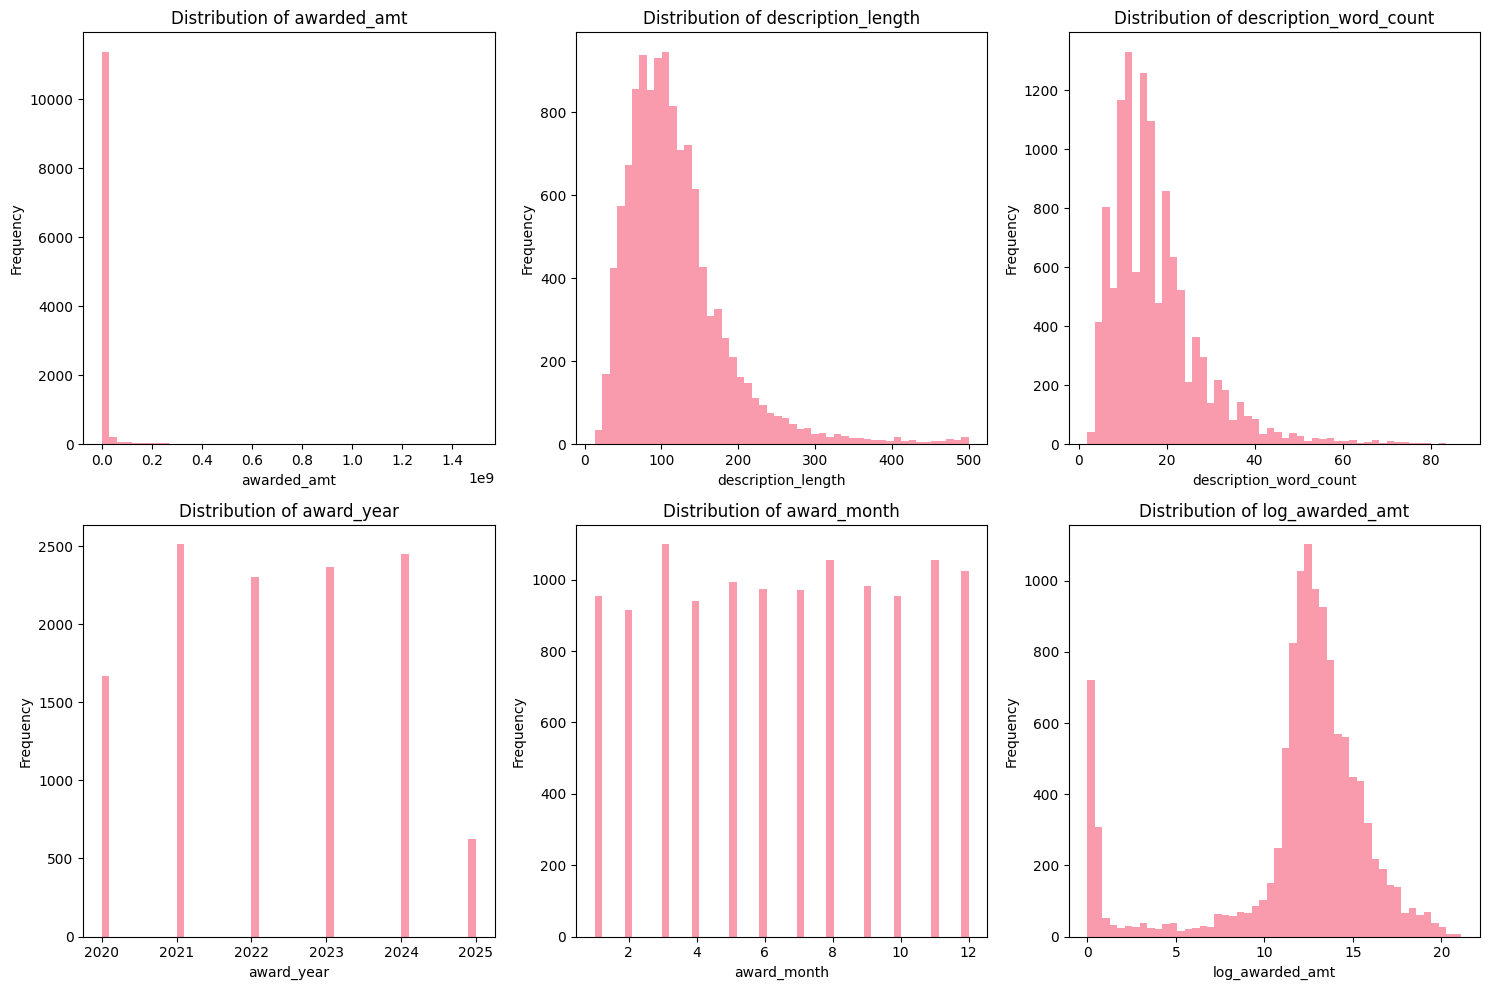

In [8]:
# Numerical features distribution
numerical_features = [
    'awarded_amt', 'description_length', 'description_word_count',
    'award_year', 'award_month', 'log_awarded_amt'
]

available_numerical = [col for col in numerical_features if col in df_processed.columns]

if available_numerical:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, feature in enumerate(available_numerical[:6]):
        if i < len(axes):
            axes[i].hist(df_processed[feature].dropna(), bins=50, alpha=0.7)
            axes[i].set_title(f'Distribution of {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Frequency')
    
    # Hide empty subplots
    for i in range(len(available_numerical), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
else:
    print("No numerical features found for distribution analysis")

## 8. Categorical Features Analysis

Analyze categorical features and their encodings.


AGENCY Analysis:
  Unique values: 111
  Top 10 values:
agency
Housing and Development Board                        1079
Public Utilities Board                                678
Agency for Science, Technology and Research           671
Land Transport Authority                              569
People's Association                                  461
Ministry of Home Affairs - Ministry Headquarter 1     447
Jurong Town Corporation                               395
National Environment Agency                           362
Ministry of Education                                 351
Ministry of Foreign Affairs                           333
Name: count, dtype: int64


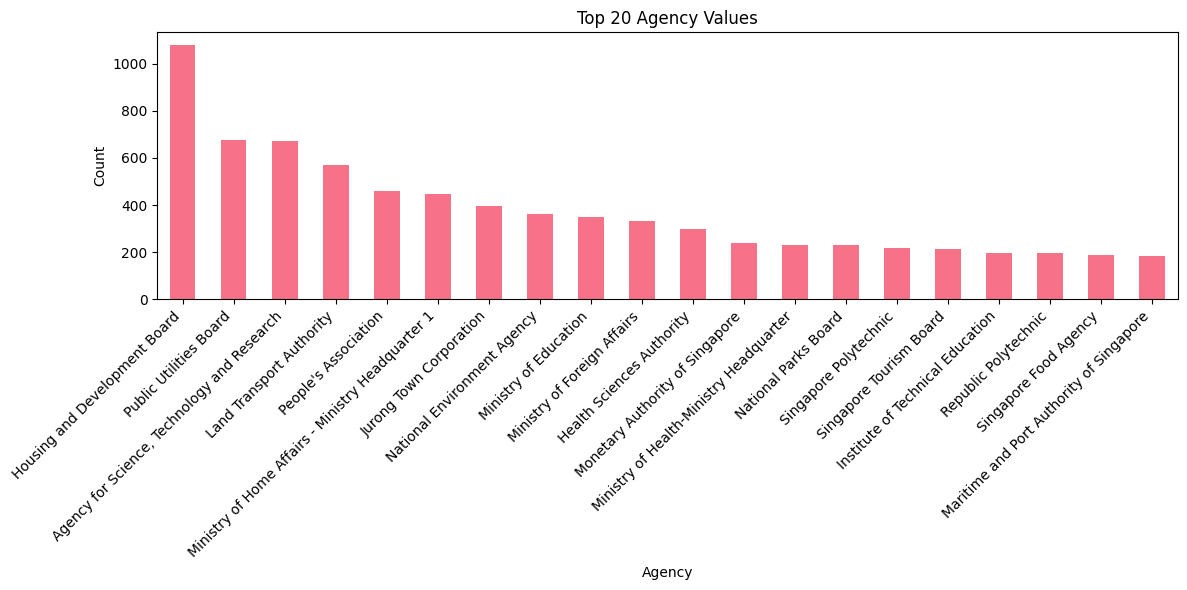


SUPPLIER_NAME Analysis:
  Unique values: 4134
  Top 10 values:
supplier_name
Unknown                                             699
NCS PTE. LTD.                                       148
WSH EXPERTS PTE. LTD.                                89
KPMG SERVICES PTE. LTD.                              63
FUJITSU ASIA PTE LTD                                 56
AECOM SINGAPORE PTE. LTD.                            55
ERNST & YOUNG ADVISORY PTE. LTD.                     53
AGILENT TECHNOLOGIES SINGAPORE (SALES) PTE. LTD.     43
C&W SERVICES (S) PTE. LTD.                           42
ACCENTURE SG SERVICES PTE. LTD.                      39
Name: count, dtype: int64


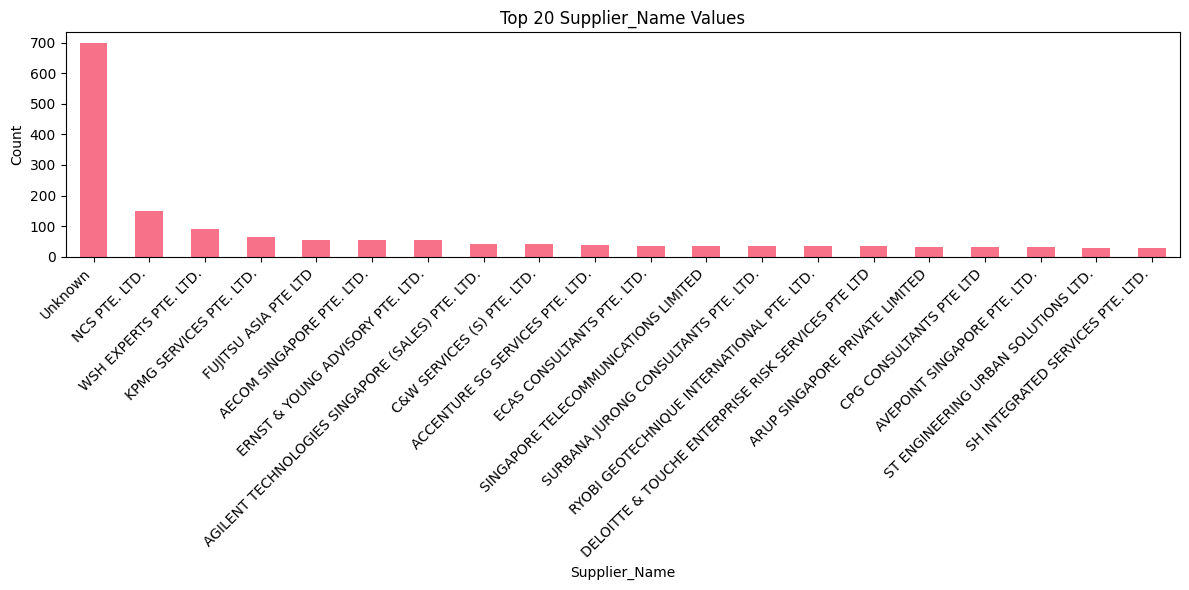


TENDER_DETAIL_STATUS Analysis:
  Unique values: 4
  Top 10 values:
tender_detail_status
Awarded to Suppliers         9174
Awarded by Items             1614
Awarded to No Suppliers       699
Award by interface record     428
Name: count, dtype: int64


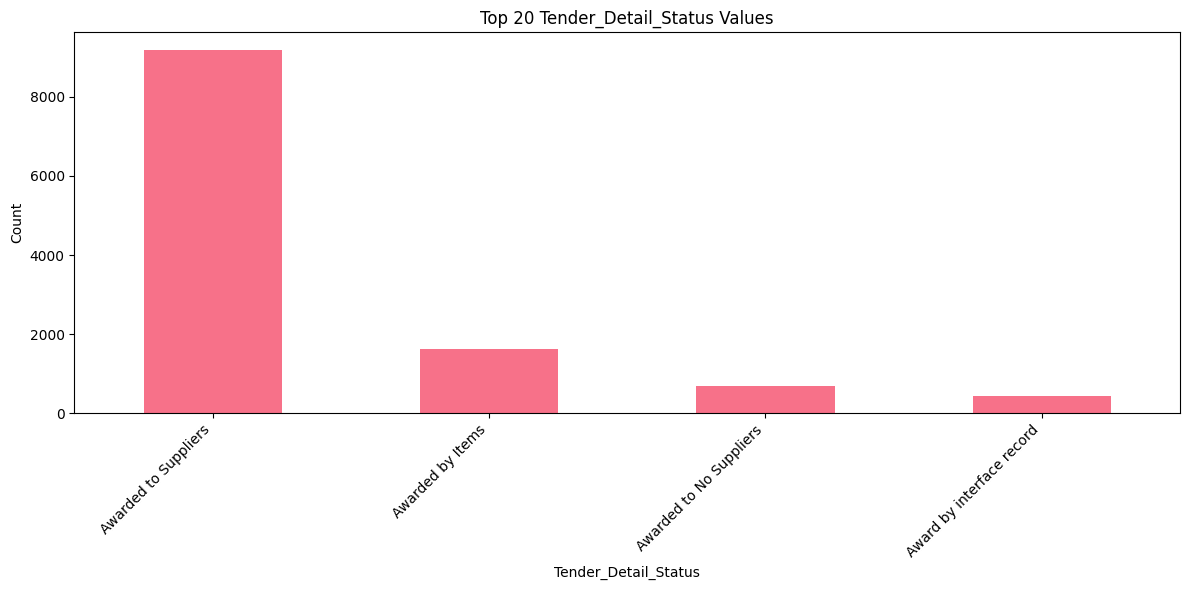

In [9]:
# Categorical features analysis
categorical_features = ['agency', 'supplier_name', 'tender_detail_status']
available_categorical = [col for col in categorical_features if col in df_processed.columns]

for feature in available_categorical:
    print(f"\n{feature.upper()} Analysis:")
    value_counts = df_processed[feature].value_counts()
    print(f"  Unique values: {len(value_counts)}")
    print(f"  Top 10 values:")
    print(value_counts.head(10))
    
    # Plot top 20 values
    if len(value_counts) > 0:
        plt.figure(figsize=(12, 6))
        value_counts.head(20).plot(kind='bar')
        plt.title(f'Top 20 {feature.title()} Values')
        plt.xlabel(feature.title())
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

## 9. Award Analysis

Analyze award amounts and patterns.

Award Analysis:
  Total tenders: 11915
  Awarded tenders: 11216
  Award rate: 94.1%

Award Amount Statistics:
count    1.121600e+04
mean     9.095730e+06
std      5.147683e+07
min      1.000000e-02
25%      1.236125e+05
50%      3.864721e+05
75%      1.742623e+06
max      1.493179e+09
Name: awarded_amt, dtype: float64


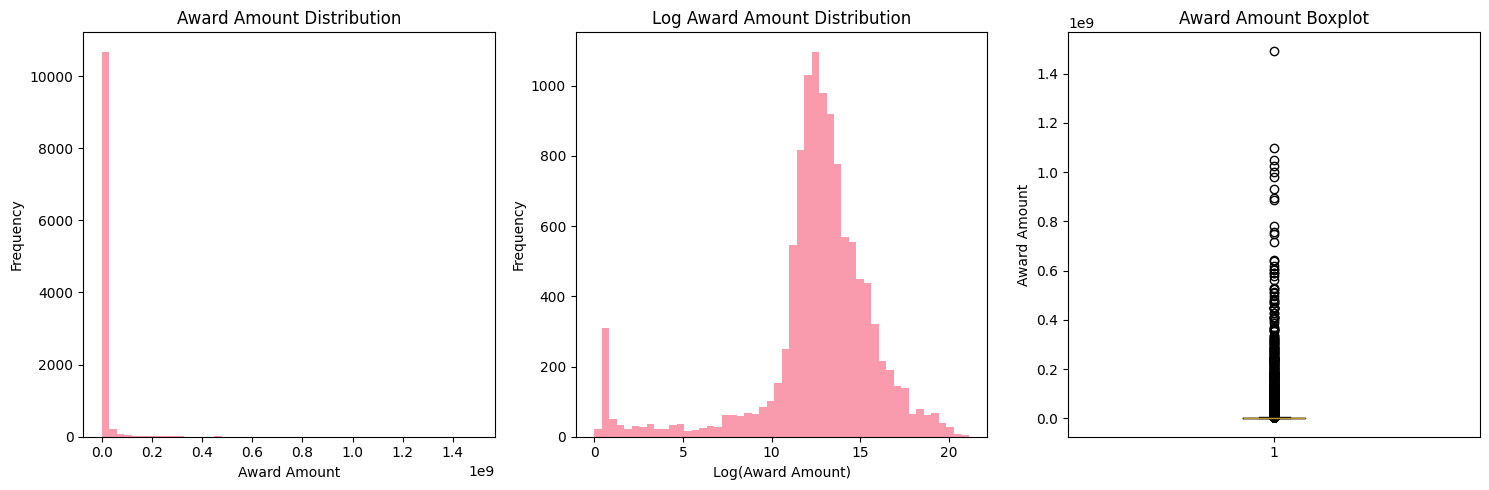

In [10]:
# Award analysis
if 'awarded_amt' in df_processed.columns:
    # Award statistics
    awarded_df = df_processed[df_processed['awarded_amt'] > 0]
    
    print(f"Award Analysis:")
    print(f"  Total tenders: {len(df_processed)}")
    print(f"  Awarded tenders: {len(awarded_df)}")
    print(f"  Award rate: {len(awarded_df) / len(df_processed) * 100:.1f}%")
    
    if len(awarded_df) > 0:
        print(f"\nAward Amount Statistics:")
        print(awarded_df['awarded_amt'].describe())
        
        # Award amount distribution
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.hist(awarded_df['awarded_amt'], bins=50, alpha=0.7)
        plt.title('Award Amount Distribution')
        plt.xlabel('Award Amount')
        plt.ylabel('Frequency')
        
        plt.subplot(1, 3, 2)
        plt.hist(np.log1p(awarded_df['awarded_amt']), bins=50, alpha=0.7)
        plt.title('Log Award Amount Distribution')
        plt.xlabel('Log(Award Amount)')
        plt.ylabel('Frequency')
        
        plt.subplot(1, 3, 3)
        plt.boxplot(awarded_df['awarded_amt'])
        plt.title('Award Amount Boxplot')
        plt.ylabel('Award Amount')
        
        plt.tight_layout()
        plt.show()
else:
    print("Award amount column not found")

## 10. Data Preparation for Modeling

Prepare datasets for different modeling tasks.

In [11]:
# Prepare data for classification (award status prediction)
print("\n=== Preparing Data for Classification ===")
X_train_clf, X_test_clf, y_train_clf, y_test_clf = preprocessor.prepare_for_modeling(
    df_processed, target_type='classification'
)

print(f"Classification dataset:")
print(f"  Training features shape: {X_train_clf.shape}")
print(f"  Test features shape: {X_test_clf.shape}")
print(f"  Training target shape: {y_train_clf.shape}")
print(f"  Test target shape: {y_test_clf.shape}")

# Display class distribution
print(f"\nClass distribution:")
unique, counts = np.unique(y_train_clf, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Class {label}: {count} samples ({count/len(y_train_clf)*100:.1f}%)")


=== Preparing Data for Classification ===

=== Preparing Data for Classification Modeling ===
Using features: ['agency_encoded', 'supplier_name_encoded', 'tender_detail_status_encoded', 'awarded_amt', 'description_length', 'description_word_count', 'award_year', 'award_month', 'award_quarter']
Training set: (9532, 9)
Test set: (2383, 9)
Classification dataset:
  Training features shape: (9532, 9)
  Test features shape: (2383, 9)
  Training target shape: (9532,)
  Test target shape: (2383,)

Class distribution:
  Class 0: 565 samples (5.9%)
  Class 1: 8967 samples (94.1%)


In [12]:
# Prepare data for clustering
print("\n=== Preparing Data for Clustering ===")
agency_features, supplier_features = preprocessor.prepare_for_modeling(
    df_processed, target_type='clustering'
)

print(f"\nAgency clustering features:")
print(f"  Shape: {agency_features.shape}")
print(f"  Columns: {agency_features.columns.tolist()}")
display(agency_features.head())

print(f"\nSupplier clustering features:")
print(f"  Shape: {supplier_features.shape}")
print(f"  Columns: {supplier_features.columns.tolist()}")
display(supplier_features.head())


=== Preparing Data for Clustering ===

=== Preparing Data for Clustering Modeling ===

=== Preparing Data for Clustering ===
Agency features shape: (110, 6)
Supplier features shape: (4133, 6)

Agency clustering features:
  Shape: (110, 6)
  Columns: ['agency', 'total_spend', 'avg_spend', 'num_tenders', 'std_spend', 'num_suppliers']


,agency,total_spend,avg_spend,num_tenders,std_spend,num_suppliers
0,Accounting And Corporate Regulatory Authority,1.216789e+08,1.106171e+07,11,3.236615e+07,9
1,"Agency for Science, Technology and Research",7.496841e+08,1.178749e+06,636,3.310209e+06,379
2,Anglo-Chinese School (Independent)\t,7.845466e+06,3.138186e+05,25,3.951447e+05,22
3,Assumption Pathway School,2.174881e+06,1.812401e+05,12,2.269030e+05,10
4,Attorney-General's Chambers,5.974186e+07,1.927157e+06,31,2.877772e+06,24



Supplier clustering features:
  Shape: (4133, 6)
  Columns: ['supplier', 'total_awards', 'avg_award', 'num_contracts', 'std_awards', 'num_agencies']


,supplier,total_awards,avg_award,num_contracts,std_awards,num_agencies
0,"*SCAPE CO., LTD.",6320.00,6.320000e+03,1,NaN,1
1,01 COMPUTER SYSTEM PTE LTD,10750737.96,1.535820e+06,7,2.302777e+06,4
2,07-Jul,252712.00,2.527120e+05,1,NaN,1
3,1 BISHAN MEDICAL PTE. LTD.,910090.20,3.033634e+05,3,5.253627e+05,3
4,1 K PRODUCTIONS PTE. LTD.,100.00,1.000000e+02,1,NaN,1


## 11. Save Processed Data and Preprocessor

Save the processed data and preprocessor for use in modeling notebook.

In [13]:
# Save processed data and clustering features
output_dir = Path().absolute().parent / 'Outputs'
output_dir.mkdir(exist_ok=True)

# Save main processed data
processed_path = output_dir / 'tender_data_processed.csv'
df_processed.to_csv(processed_path, index=False)
print(f"Main processed data saved to: {processed_path}")

# Save clustering features
agency_features_path = output_dir / 'agency_clustering_features.csv'
supplier_features_path = output_dir / 'supplier_clustering_features.csv'

agency_features.to_csv(agency_features_path, index=False)
supplier_features.to_csv(supplier_features_path, index=False)

print(f"Agency clustering features saved to: {agency_features_path}")
print(f"Supplier clustering features saved to: {supplier_features_path}")

Main processed data saved to: /Users/aamirsyedaltaf/Documents/dos5022/Outputs/tender_data_processed.csv
Agency clustering features saved to: /Users/aamirsyedaltaf/Documents/dos5022/Outputs/agency_clustering_features.csv
Supplier clustering features saved to: /Users/aamirsyedaltaf/Documents/dos5022/Outputs/supplier_clustering_features.csv


In [14]:
# Save preprocessor object
import pickle
preprocessor_path = output_dir / 'preprocessor.pkl'
with open(preprocessor_path, 'wb') as f:
    pickle.dump(preprocessor, f)
print(f"Preprocessor saved to: {preprocessor_path}")

Preprocessor saved to: /Users/aamirsyedaltaf/Documents/dos5022/Outputs/preprocessor.pkl
